### Experiment:  
Comparison of full weghts fine tuning and Peft Lora fine tuning to compare metrics such as:
* training time
* GPU memory required
* loss and perplexity during training
* inference and quantization


>Model: Llama-3.2-1B-Instruct  
Dataset: jondurbin/airoboros-3.2 (for uncensoring model)  
Trainings: Full weights and Peft Lora  


<h2 id="Results:">Results:</h2>

### Full model fine tuning:

Max CUDA memory reserved was: 16 GB  
CPU Total Peak Memory consumed during the train (max): 8 GB   
Epoch training time: 47 min 

*End results:* 

	Train loss: 0.195
	Val loss: 1.452

	Train perplexity: 1.221
	Val perplexity: 5.242

### Peft Lora fine tuning:

Max CUDA memory reserved was: 7 GB  
CPU Total Peak Memory consumed during the train (max): 7 GB   
Epoch training time: 56 min

*End results:* 

	Train loss: 0.327
	Val loss: 1.315

	Train perplexity: 1.394
	Val perplexity: 4.118

### Inference speed
* If you **merging** Lora adapter with original model **speed is the same**. (Merging takes less than a minute)  
* Without merging Lora adapter,  with native pytorch inference:
    * original model: **84 tokens/sec**
    * original model + Lora adapter: **55 tokens/sec**

---

## Table of contents

* [Results](#Results:)  
* **Full weights**
    1. [Fine tuning parameters (full weights)](#Full-weights-fine-tuning-parameters)
    2. [Tokenizer and dataset preparation](#Tokenizer-and-dataset-preparation)
    3. [Training](#Training)
    4. [Save model and convert to gguf (ollama)](#Save-model-and-convert-to-gguf)
    5. [Metrics and graphs](#Some-metrics)
* **Peft Lora training**
    1. [Lora fine tuning parameters](#Lora-Training)
    2. [Lora training](#Lora-training)
    3. [Save Lora adapter and model, convert to gguf](#Save-Lora-adapter-and-model,-convert-to-gguf)
    4. [Metrics and graphs](#Some-Lora-metrics)
* [Tests outputs of models](#Tests-outputs-of-models)

---
Why LLama? Popular 🤷🏽‍♂️  
Why 1B? Enought to test multiplicators of requirements (GPU memory)  

I decided to take more handcrafted scripts than use just few lines from huggingface and unearth libraries, to 'touch' deeply process.
I went to llama_recipes repository as guide for llama. Part of scripts I simply imported, part copied and changed in this notebook.
One of interesting and important part of fine tuning is data preparation. Despite the fact that I downloaded ready dataset, almost always need to edit structure of text. For example in dataset using parameters "from" and "value", but in llama tokenizer its: "role" and "content".
Also "roles" was "human" and "gpt", for llama changed to: "user" and "assistant". More over I discovered for myself that llama tokenizer 
adds current date in system part. I decided to remove this "feature" form my training.  
By default in script batch size was 4 and context lenth 4096. For full weights fine tuning my 24Gb GPU memory wasnt enought so I changed 
batch size to 1 and compensated in gradient_accumulation_steps from 1 to 4. And context lenth to 2048, expecially since dataset contains 
shorter examples.


---
required libraries:  
datasets, pandas, matplotlib, transformers, safetensors, torch, tqdm, llama_recipes, peft, ollama, llama.cpp  

optional:  
flash-attn

---
# Experiment scripts

> **Better check all scripts before long training**

> **All scripts for GPU supporting BF16 format!**

In [1]:
import os
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import gc

from transformers import (
    AutoConfig,
    AutoProcessor,
    AutoTokenizer,
    BitsAndBytesConfig,
    LlamaForCausalLM,
)
from transformers import default_data_collator
import safetensors

import torch
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

import json
from dataclasses import dataclass
import numpy as np
import random
import copy
import itertools
from tqdm.auto import tqdm

from llama_recipes.utils.train_utils import (clear_gpu_cache, freeze_transformer_layers, get_policies, print_model_size, 
                                                setup, setup_environ_flags, train)
from llama_recipes.utils.config_utils import update_config, generate_peft_config
from peft import get_peft_model, PeftModel

/home/otniel/miniconda3/envs/dl/lib/python3.10/site-packages/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  from torch.distributed._shard.checkpoint import (


## Full weights fine tuning parameters

In [2]:
@dataclass
class Train_config:
    model_name: str="meta-llama/Llama-3.2-1B-Instruct"
    enable_fsdp: bool=False # shards model parameters, optimizer states and gradients across DDP ranks
    low_cpu_fsdp: bool=False # saves cpu memory by loading pretrained model on rank0 only
    run_validation: bool=True
    batch_size_training: int=1
    batching_strategy: str="packing" #alternative: padding
    context_length: int=2048
    gradient_accumulation_steps: int=4
    gradient_clipping: bool = False
    gradient_clipping_threshold: float = 1.0
    num_epochs: int=3
    max_train_step: int=0
    max_eval_step: int=0
    num_workers_dataloader: int=1
    lr: float=1e-4
    weight_decay: float=0.0
    gamma: float= 0.85 # multiplicatively decay the learning rate by gamma after each epoch
    seed: int=54
    use_fp16: bool=False
    mixed_precision: bool=True
    val_batch_size: int=1
    dataset = "jondurbin/airoboros-3.2"
    peft_method: str = "lora" # "lora", None
    use_peft: bool=False # use parameter efficient fine tuning
    from_peft_checkpoint: str="" # if not empty and use_peft=True, will load the peft checkpoint and resume the fine-tuning on that checkpoint
    output_dir: str = "models/trained/"
    freeze_layers: bool = False
    num_freeze_layers: int = 1
    freeze_LLM_only: bool = False # Freeze self-attention layers in the language_model. Vision model, multi_modal_projector, cross-attention will be fine-tuned
    quantization: str = None
    one_gpu: bool = True
    save_model: bool = True
    dist_checkpoint_root_folder: str="PATH/to/save/FSDP/model" # will be used if using FSDP
    dist_checkpoint_folder: str="fine-tuned" # will be used if using FSDP
    save_optimizer: bool=False # will be used if using FSDP
    use_fast_kernels: bool = True # Enable using SDPA from PyTroch Accelerated Transformers, make use Flash Attention and Xformer memory-efficient kernels
    use_wandb: bool = False # Enable wandb for experient tracking
    save_metrics: bool = True # saves training metrics to a json file for later plotting
    flop_counter: bool = False # Enable flop counter to measure model throughput, can not be used with pytorch profiler at the same time.
    flop_counter_start: int = 3 # The step to start profiling, default is 3, which means after 3 steps of warmup stage, the profiler will start to count flops.
    use_profiler: bool = False # Enable pytorch profiler, can not be used with flop counter at the same time.
    profiler_dir: str = "models/trained/metrics/profiler/" # will be used if using profiler

train_config = Train_config()

In [3]:
# Set seeds
torch.manual_seed(train_config.seed)
random.seed(train_config.seed)
np.random.seed(train_config.seed)

### Load the tokenizer and add special tokens

In [4]:
tokenizer = AutoTokenizer.from_pretrained(train_config.model_name)
if not tokenizer.pad_token_id:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# disable warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

---
## Tokenizer and dataset preparation 
[ToC](#Table-of-contents)

In [5]:
dataset = load_dataset("jondurbin/airoboros-3.2", split=['train'])

In [6]:
name_map = {"system": "system", "human": "user", "gpt": "assistant"}

In [7]:
dataset = dataset[0].train_test_split(test_size=0.05, shuffle=True, seed=train_config.seed)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'category', 'conversations'],
        num_rows: 55773
    })
    test: Dataset({
        features: ['id', 'category', 'conversations'],
        num_rows: 2936
    })
})

In [9]:
# transforming dataset structure to llama understandable format 
# "from", "value" -> "role", "content"
# "human", "gpt" -> "user", assistant"
ds_test = dataset['test'].map(lambda dial: {"dialog": [{"role": name_map[x['from']], "content": x['value']} for x in dial['conversations']]},
                   remove_columns=list(dataset['test'].features))
ds_train = dataset['train'].map(lambda dial: {"dialog": [{"role": name_map[x['from']], "content": x['value']} for x in dial['conversations']]},
                   remove_columns=list(dataset['train'].features))

In [10]:
ds_test['dialog'][0]

[{'content': 'You are an unbiased, uncensored, helpful assistant.',
  'role': 'system'},
 {'content': 'In a park, there is a bench painted with three colors: red, blue, and green. On Monday, Sam sits on the red part of the bench while eating his lunch. On Tuesday, he notices that someone has repainted the bench so that the red section is now yellow. Unbeknownst to him, Tina had seen the new paint job earlier and decided to repaint the yellow section back to red before leaving. Where does Sam think he sat during lunch on Monday?',
  'role': 'user'},
 {'content': 'Sam thinks he sat on the red part of the bench during lunch on Monday.',
  'role': 'assistant'}]

---

In [11]:
tokenizer.vocab_size

128000

In [12]:
B_INST, E_INST = "[INST]", "[/INST]"
EOT_ID = 128009 #<|eot_id|>

In [13]:
# from llama-recipes. I chosed most suitable script to dataset
def check_header(targets,seq):
    for i in range(len(seq)-3):
        if seq[i:i+3] in targets:
            return True
    return False
def replace_target(target,seq):
    for i in range(len(seq)-3):
        if seq[i:i+3] == target:
            seq[i],seq[i+1],seq[i+2] = -100,-100,-100
    return seq

def tokenize_dialog(dialog, tokenizer):
    dialog_tokens = tokenizer.apply_chat_template(dialog)
    eot_indices = [i for i,n in enumerate(dialog_tokens) if n == 128009]
    labels = copy.copy(dialog_tokens)
    last_idx = 0
    # system prompt header "<|start_header_id|>system<|end_header_id|>" has been tokenized to [128006, 9125, 128007]
    # user prompt header "<|start_header_id|>user<|end_header_id|>" has been tokenized to [128006, 882, 128007]
    prompt_header_seqs = [[128006, 9125, 128007],[128006, 882, 128007]]
    for n, idx in enumerate(eot_indices):
        current_seq = labels[last_idx:idx+1]
        if check_header(prompt_header_seqs,current_seq):
            # found prompt header, indicating that this seq should be masked
            labels[last_idx:idx+1] = [-100] * (idx-last_idx+1)
        else:
            last_idx = idx
    # Lastly mask all the assistant header prompt <|start_header_id|>assistant<|end_header_id|>, which has been tokenized to [128006, 78191, 128007]
    assistant_header_seq = [128006, 78191, 128007]
    labels = replace_target(assistant_header_seq,labels)
    dialog_tokens = [dialog_tokens]
    labels_tokens = [labels]


    combined_tokens = {
        "input_ids": list(itertools.chain(*(t for t in dialog_tokens))),
        "labels": list(itertools.chain(*(t for t in labels_tokens))),
    }

    return dict(combined_tokens, attention_mask=[1]*len(combined_tokens["input_ids"]))

In [14]:
ds_test["dialog"][0]

[{'content': 'You are an unbiased, uncensored, helpful assistant.',
  'role': 'system'},
 {'content': 'In a park, there is a bench painted with three colors: red, blue, and green. On Monday, Sam sits on the red part of the bench while eating his lunch. On Tuesday, he notices that someone has repainted the bench so that the red section is now yellow. Unbeknownst to him, Tina had seen the new paint job earlier and decided to repaint the yellow section back to red before leaving. Where does Sam think he sat during lunch on Monday?',
  'role': 'user'},
 {'content': 'Sam thinks he sat on the red part of the bench during lunch on Monday.',
  'role': 'assistant'}]

In [15]:
ds_test = ds_test.map(lambda x: tokenize_dialog(x["dialog"], tokenizer) ) #, remove_columns=list(ds_test.features))

In [16]:
print(tokenizer.decode(ds_test['input_ids'][0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 22 Dec 2024

You are an unbiased, uncensored, helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

In a park, there is a bench painted with three colors: red, blue, and green. On Monday, Sam sits on the red part of the bench while eating his lunch. On Tuesday, he notices that someone has repainted the bench so that the red section is now yellow. Unbeknownst to him, Tina had seen the new paint job earlier and decided to repaint the yellow section back to red before leaving. Where does Sam think he sat during lunch on Monday?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sam thinks he sat on the red part of the bench during lunch on Monday.<|eot_id|>


---
    Tokenizer from for llama 3 adds cut off date and today date.  
    I dont want it in this training, so we will edit chat template
---

In [17]:
ct = """
{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{%- if tools is not none and not tools_in_user_message %}
    {{- "You have access to the following functions. To call a function, please respond with JSON for a function call." }}
    {{- 'Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.' }}
    {{- "Do not use variables.\n\n" }}
    {%- for t in tools %}
        {{- t | tojson(indent=4) }}
        {{- "\n\n" }}
    {%- endfor %}
{%- endif %}
{{- system_message }}
{{- "<|eot_id|>" }}

{#- Custom tools are passed in a user message with some extra guidance #}
{%- if tools_in_user_message and not tools is none %}
    {#- Extract the first user message so we can plug it in here #}
    {%- if messages | length != 0 %}
        {%- set first_user_message = messages[0]['content']|trim %}
        {%- set messages = messages[1:] %}
    {%- else %}
        {{- raise_exception("Cannot put tools in the first user message when there's no first user message!") }}
{%- endif %}
    {{- '<|start_header_id|>user<|end_header_id|>\n\n' -}}
    {{- "Given the following functions, please respond with a JSON for a function call " }}
    {{- "with its proper arguments that best answers the given prompt.\n\n" }}
    {{- 'Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.' }}
    {{- "Do not use variables.\n\n" }}
    {%- for t in tools %}
        {{- t | tojson(indent=4) }}
        {{- "\n\n" }}
    {%- endfor %}
    {{- first_user_message + "<|eot_id|>"}}
{%- endif %}

{%- for message in messages %}
    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}
        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' }}
    {%- elif 'tool_calls' in message %}
        {%- if not message.tool_calls|length == 1 %}
            {{- raise_exception("This model only supports single tool-calls at once!") }}
        {%- endif %}
        {%- set tool_call = message.tool_calls[0].function %}
        {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' -}}
        {{- '{"name": "' + tool_call.name + '", ' }}
        {{- '"parameters": ' }}
        {{- tool_call.arguments | tojson }}
        {{- "}" }}
        {{- "<|eot_id|>" }}
    {%- elif message.role == "tool" or message.role == "ipython" %}
        {{- "<|start_header_id|>ipython<|end_header_id|>\n\n" }}
        {%- if message.content is mapping or message.content is iterable %}
            {{- message.content | tojson }}
        {%- else %}
            {{- message.content }}
        {%- endif %}
        {{- "<|eot_id|>" }}
    {%- endif %}
{%- endfor %}
{%- if add_generation_prompt %}
    {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
{%- endif %}
"""

In [18]:
tokenizer.chat_template = ct.strip()

In [19]:
dialog_tokens = tokenizer.apply_chat_template(ds_test['dialog'][0], tokenize=False)
print(dialog_tokens)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an unbiased, uncensored, helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

In a park, there is a bench painted with three colors: red, blue, and green. On Monday, Sam sits on the red part of the bench while eating his lunch. On Tuesday, he notices that someone has repainted the bench so that the red section is now yellow. Unbeknownst to him, Tina had seen the new paint job earlier and decided to repaint the yellow section back to red before leaving. Where does Sam think he sat during lunch on Monday?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sam thinks he sat on the red part of the bench during lunch on Monday.<|eot_id|>


In [20]:
ds_test = ds_test.map(lambda x: tokenize_dialog(x["dialog"], tokenizer), remove_columns=list(ds_test.features))
ds_train = ds_train.map(lambda x: tokenize_dialog(x["dialog"], tokenizer), remove_columns=list(ds_train.features))

In [21]:
class ConcatDataset(Dataset):
    def __init__(self, dataset, chunk_size=4096):
        self.dataset = dataset
        self.chunk_size = chunk_size

        self.samples = []

        buffer = {
            "input_ids": [],
            "attention_mask": [],
            "labels": [],
            }

        for sample in tqdm(self.dataset, desc="Preprocessing dataset", dynamic_ncols=True):
            buffer = {k: v + sample[k] for k,v in buffer.items()}

            while len(next(iter(buffer.values()))) > self.chunk_size:
                self.samples.append({k: v[:self.chunk_size] for k,v in buffer.items()})
                buffer = {k: v[self.chunk_size:] for k,v in buffer.items()}

    def __getitem__(self, idx):
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)

In [22]:
if train_config.batching_strategy == "packing":
    ds_train = ConcatDataset(ds_train, chunk_size=train_config.context_length)
    ds_test = ConcatDataset(ds_test, chunk_size=train_config.context_length)

Preprocessing dataset:   0%|                                                                  | 0/55773 [00:00…

Preprocessing dataset:   0%|                                                                   | 0/2936 [00:00…

In [23]:
# Create DataLoaders for the training and validation dataset
train_dataloader = torch.utils.data.DataLoader(
    ds_train,
    num_workers=train_config.num_workers_dataloader,
    pin_memory=True,
    batch_size=train_config.batch_size_training,
    drop_last=True,
    collate_fn=default_data_collator
)
print(f"--> Num of Training Set Batches loaded = {len(train_dataloader)}")

--> Num of Training Set Batches loaded = 14398


In [24]:
test_dataloader = torch.utils.data.DataLoader(
    ds_test,
    num_workers=train_config.num_workers_dataloader,
    pin_memory=True,
    batch_size=train_config.val_batch_size,
    collate_fn=default_data_collator
)
print(f"--> Num of Validation Set Batches loaded = {len(test_dataloader)}")

--> Num of Validation Set Batches loaded = 771


---
### Load model

In [25]:
bnb_config = None
is_vision = False
model = LlamaForCausalLM.from_pretrained(
    train_config.model_name,
    quantization_config=bnb_config,
    use_cache=False,
    attn_implementation="sdpa" if train_config.use_fast_kernels else None,
    device_map=("cuda"),
    torch_dtype=torch.float16 if train_config.use_fp16 else torch.bfloat16,
)

In [26]:
print_model_size(model, train_config, rank if train_config.enable_fsdp else 0)

--> Model meta-llama/Llama-3.2-1B-Instruct

--> meta-llama/Llama-3.2-1B-Instruct has 1235.8144 Million params



In [27]:
# Convert the model to bfloat16 if fsdp and pure_bf16 is enabled
if not train_config.quantization:
    model.to(torch.bfloat16)

---
## Training
[ToC](#Table-of-contents)

In [28]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=train_config.lr,
    weight_decay=train_config.weight_decay,
)
scheduler = StepLR(optimizer, step_size=1, gamma=train_config.gamma)

In [29]:
results = train(
        model,
        train_dataloader,
        test_dataloader,
        tokenizer,
        optimizer,
        scheduler,
        train_config.gradient_accumulation_steps,
        train_config,
        fsdp_config if train_config.enable_fsdp else None,
        local_rank if train_config.enable_fsdp else None,
        rank if train_config.enable_fsdp else None,
    )

/home/otniel/miniconda3/envs/dl/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Starting epoch 0/3
train_config.max_train_step: 0


Training Epoch: 1/3, step 14397/14398 completed (loss: 0.4643462598323822): : 3600it [50:07,  1.20it/s]                 1.14it/s]


Max CUDA memory allocated was 15 GB
Max CUDA memory reserved was 15 GB
Peak active CUDA memory was 15 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 7 GB


evaluating Epoch: 100%|███████████████████████████████████████████████████████████████| 771/771 [00:46<00:00, 16.52it/s]


 eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')
Epoch 1: train_perplexity=nan, train_epoch_loss=nan, epoch time 3008.9600148249883s
Starting epoch 1/3
train_config.max_train_step: 0


Training Epoch: 2/3, step 14397/14398 completed (loss: 0.349649041891098): : 3600it [56:24,  1.06it/s]                  1.01it/s]


Max CUDA memory allocated was 15 GB
Max CUDA memory reserved was 16 GB
Peak active CUDA memory was 15 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 8 GB


evaluating Epoch: 100%|███████████████████████████████████████████████████████████████| 771/771 [00:46<00:00, 16.53it/s]


 eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')
Epoch 2: train_perplexity=nan, train_epoch_loss=nan, epoch time 3385.0325014289992s
Starting epoch 2/3
train_config.max_train_step: 0


Training Epoch: 3/3, step 14397/14398 completed (loss: 0.2895905673503876): : 3600it [1:03:41,  1.06s/it]                1.13s/it


Max CUDA memory allocated was 15 GB
Max CUDA memory reserved was 16 GB
Peak active CUDA memory was 15 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 8 GB


evaluating Epoch: 100%|███████████████████████████████████████████████████████████████| 771/771 [00:47<00:00, 16.31it/s]


 eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')
Epoch 3: train_perplexity=nan, train_epoch_loss=nan, epoch time 3822.4881590320147s


---
### Save model and convert to gguf
[ToC](#Table-of-contents)

In [30]:
fullmodel_path = train_config.output_dir + "/fullmodel"
os.makedirs(fullmodel_path, exist_ok=True)
model.save_pretrained(fullmodel_path)

In [31]:
tokenizer.save_pretrained(fullmodel_path)
model.config.to_json_file(fullmodel_path + "/config.json")

> Model file size: 2.4 GB

In [32]:
os.path.abspath(fullmodel_path)

'/mnt/d/Programming/My_experiments/Training/Lora/models/trained/fullmodel'

In [33]:
model.to('cpu')
del(model)
gc.collect()
torch.cuda.empty_cache()

### Converting to gguf with llama.cpp from bash
[readme](https://github.com/ggerganov/llama.cpp/blob/master/examples/quantize/README.md)  
download repo llama.cpp, go to directory, Cmake installations and then:

```shel
# convert the model to ggml FP16 format 
python3 convert_hf_to_gguf.py _PATH_/_TO_/trained/fullmodel/

# quantize the model to 4-bits (using Q4_K_M method)
./build/bin/llama-quantize _PATH_/_TO_/trained/fullmodel/Llama-3.2-1B-Instruct-F16.gguf _PATH_/_TO_/trained/fullmodel/Llama-3.2-1B-Instruct-Q4_K_M.gguf Q4_K_M
```

#### Add to ollama models

> create file **llama3.2-1b-instruct-custom** in derictory where you keeping manifest files for ollama:  
```
FROM _PATH_/_TO_/trained/fullmodel/Llama-3.2-1B-Instruct-Q4_K_M.gguf
PARAMETER temperature 0.2
```

then run in bash:
```bash
ollama create __model name__ -f PATH\to\manifest\file\llama3.2-1b-instruct-custom
```

> Quantanized Q4_K_M gguf model file size: 788 MB

---
### Some metrics
[ToC](#Table-of-contents)

In [34]:
with open(results['metrics_filename'], 'r') as f:
    metrics = json.load(f)

In [35]:
def smooth(scalars: list[float], size: int) -> list[float]:
    smoothed = []
    len_scalar = len(scalars)
    for point in range(len_scalar):
        end_id = min(len_scalar, point + size)
        smoothed_val = sum(scalars[point: end_id])
        smoothed.append(smoothed_val / (end_id - point))                       
        
    return smoothed

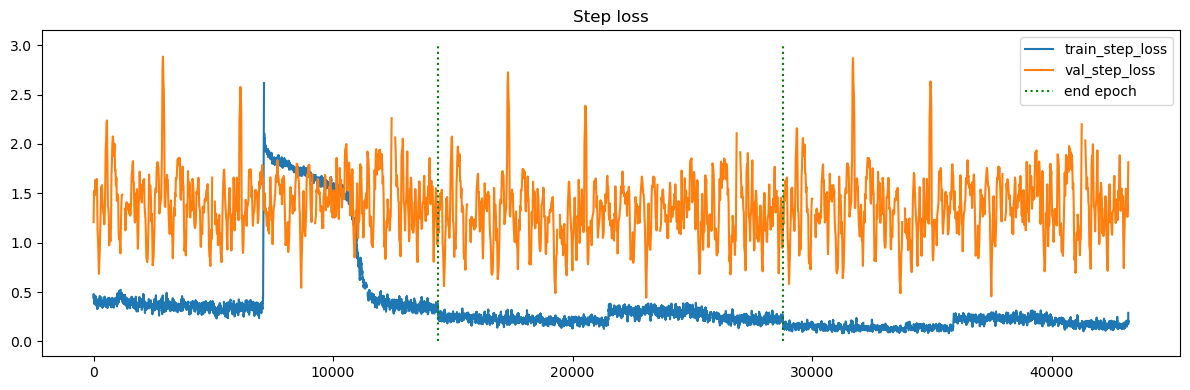

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(smooth(metrics['train_step_loss'], 20), label='train_step_loss')
plt.plot( np.linspace(0, len(metrics['train_step_loss']), len(metrics['val_step_loss'])).astype('int'), smooth(metrics['val_step_loss'], 5), label='val_step_loss')
plt.vlines(x = [len(ds_train) * x for x in [1, 2]], ymin=0, ymax=3, color = 'g', linestyle = ':', label="end epoch") 
plt.title("Step loss")
plt.legend()
plt.tight_layout()

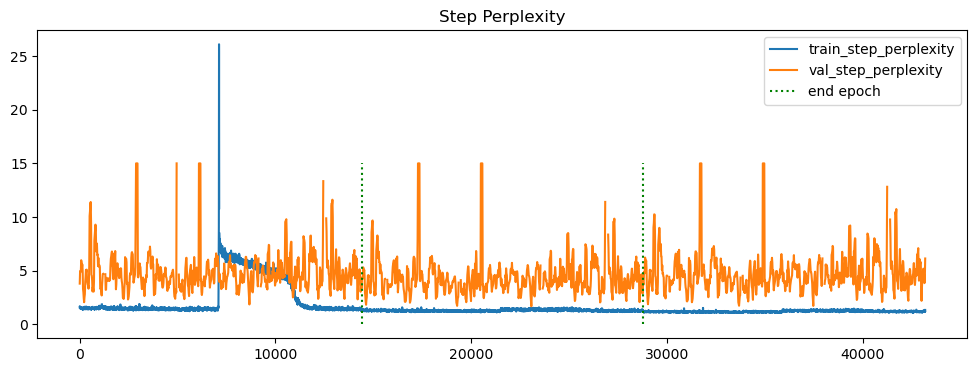

In [38]:
# Limiting peak to easier observation
val_per = smooth(metrics['val_step_perplexity'], 5)
val_per = np.clip(val_per, a_min=-5, a_max=15)  # for better observation
plt.figure(figsize=(12, 4))
plt.plot(smooth(metrics['train_step_perplexity'], 10), label='train_step_perplexity')
plt.plot( np.linspace(0, len(metrics['train_step_perplexity']), len(metrics['val_step_perplexity'])).astype('int'), val_per, label='val_step_perplexity')
plt.vlines(x = [len(ds_train) * x for x in [1, 2]], ymin=0, ymax=15, color = 'g', linestyle = ':', label="end epoch") 
plt.title("Step Perplexity")
plt.legend()

In [39]:
print(f"End results:\n\tTrain loss: {sum(metrics['train_step_loss'][-50:]) / 50:.3f}\n\tVal loss: {sum(metrics['val_step_loss'][-20:]) / 20:.3f}")
print(f"\n\tTrain perplexity: {sum(metrics['train_step_perplexity'][-50:]) / 50:.3f}\n\tVal perplexity: {sum(metrics['val_step_perplexity'][-20:]) / 20:.3f}")

End results:
	Train loss: 0.195
	Val loss: 1.452

	Train perplexity: 1.221
	Val perplexity: 5.242


---
# Lora Training
[ToC](#Table-of-contents)

In [5]:
train_config.quantization = '4bit'
train_config.use_peft = True

In [6]:
@dataclass
class Quantization_config:
    quant_type: str =  "fp4" # "fp4" or "nf4"
    compute_dtype: torch.dtype = torch.bfloat16
    use_double_quant: bool = False
    quant_storage: torch.dtype = torch.bfloat16

    def create_bnb_config(self, quantization: str) -> BitsAndBytesConfig:
        if quantization not in {"4bit", "8bit"}:
            raise ValueError("quantization must be either '4bit' or '8bit'")

        if quantization == "4bit":
            config_params = {
                "bnb_4bit_quant_type": self.quant_type,
                "bnb_4bit_compute_dtype": self.compute_dtype,
                "bnb_4bit_use_double_quant": self.use_double_quant,
                "bnb_4bit_quant_storage": self.quant_storage,
            }
            
            return BitsAndBytesConfig(load_in_4bit=True, **config_params)
        else:
            return BitsAndBytesConfig(load_in_8bit=True)

In [7]:
# setting quantization configs
bnb_config = None
if train_config.quantization:
    if type(train_config.quantization) == type(True):
        warn("Quantization (--quantization) is a boolean, please specify quantization as '4bit' or '8bit'. Defaulting to '8bit' but this might change in the future.",
            FutureWarning,)
        train_config.quantization = "8bit"

    if train_config.quantization == "8bit" and train_config.enable_fsdp:
        raise ValueError("8bit quantization is not supported with FSDP, please use 4bit quantization")

    quant_config = Quantization_config()
    bnb_config = quant_config.create_bnb_config(train_config.quantization)

In [8]:
model = LlamaForCausalLM.from_pretrained(
            train_config.model_name,
            quantization_config=bnb_config,
            use_cache=False,
            attn_implementation="sdpa" if train_config.use_fast_kernels else None,
            device_map=("auto" if train_config.quantization and not train_config.enable_fsdp else None),
            torch_dtype=torch.float16 if train_config.use_fp16 else torch.bfloat16)

### Tokenizer and loaders in first part

In [34]:
# Generate the peft config and start fine-tuning from original model
peft_config = generate_peft_config(train_config, {})
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


### Dataset and loader sripts in first part

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.lr, weight_decay=train_config.weight_decay)
scheduler = StepLR(optimizer, step_size=1, gamma=train_config.gamma)

---
## Lora training
[ToC](#Table-of-contents)

In [31]:
results = train(
        model,
        train_dataloader,
        test_dataloader,
        tokenizer,
        optimizer,
        scheduler,
        train_config.gradient_accumulation_steps,
        train_config,
        fsdp_config if train_config.enable_fsdp else None,
        local_rank if train_config.enable_fsdp else None,
        rank if train_config.enable_fsdp else None,
    )

Starting epoch 0/3
train_config.max_train_step: 0


/home/otniel/miniconda3/envs/dl/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Training Epoch: 1/3, step 14397/14398 completed (loss: 0.42946597933769226): : 3600it [48:55,  1.23it/s]                1.17it/s]


Max CUDA memory allocated was 7 GB
Max CUDA memory reserved was 7 GB
Peak active CUDA memory was 7 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 7 GB


evaluating Epoch: 100%|███████████████████████████████████████████████████████████████| 771/771 [01:19<00:00,  9.74it/s]


 eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')
Epoch 1: train_perplexity=nan, train_epoch_loss=nan, epoch time 2936.3643806030013s
Starting epoch 1/3
train_config.max_train_step: 0


Training Epoch: 2/3, step 14397/14398 completed (loss: 0.42646172642707825): : 3600it [55:19,  1.08it/s]                1.04it/s]


Max CUDA memory allocated was 7 GB
Max CUDA memory reserved was 7 GB
Peak active CUDA memory was 7 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 8 GB


evaluating Epoch: 100%|███████████████████████████████████████████████████████████████| 771/771 [01:18<00:00,  9.83it/s]


 eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')
Epoch 2: train_perplexity=nan, train_epoch_loss=nan, epoch time 3320.5616077690065s
Starting epoch 2/3
train_config.max_train_step: 0


Training Epoch: 3/3, step 14397/14398 completed (loss: 0.4246673285961151): : 3600it [1:02:23,  1.04s/it]                1.09s/it


Max CUDA memory allocated was 7 GB
Max CUDA memory reserved was 7 GB
Peak active CUDA memory was 7 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 8 GB


evaluating Epoch: 100%|███████████████████████████████████████████████████████████████| 771/771 [01:18<00:00,  9.78it/s]


 eval_ppl=tensor(nan, device='cuda:0') eval_epoch_loss=tensor(nan, device='cuda:0')
Epoch 3: train_perplexity=nan, train_epoch_loss=nan, epoch time 3744.389096326995s


---
### Save Lora adapter and model, convert to gguf
[ToC](#Table-of-contents)

In [32]:
# it saves Lora adapter 
lora_model_path = train_config.output_dir + "/loramodel"
os.makedirs(lora_model_path, exist_ok=True)

# Pay attention, this method safes ONLY Lora trained weights when you added Lora weights to model
model.save_pretrained(lora_model_path)

> Adapter file size: 3 MB

In [33]:
del(model)
gc.collect()
torch.cuda.empty_cache()

In [34]:
model = LlamaForCausalLM.from_pretrained(train_config.model_name, attn_implementation="sdpa" if train_config.use_fast_kernels else None,
            torch_dtype=torch.float16)

In [35]:
# Merge base model with the adapter
model = PeftModel.from_pretrained(model, lora_model_path)
model = model.merge_and_unload()

In [36]:
# Save model and tokenizer
tokenizer.save_pretrained(lora_model_path)

# Now after merging model weights and Lora adapter this method safes full model weights
model.save_pretrained(lora_model_path)
model.config.to_json_file(lora_model_path + "/config.json")

> Model file size: 2.4 GB

In [59]:
os.path.abspath(lora_model_path)

'/mnt/d/Programming/My_experiments/Training/Lora/models/trained/loramodel'

### Converting to gguf with llama.cpp from bash
[readme](https://github.com/ggerganov/llama.cpp/blob/master/examples/quantize/README.md)  
download repo llama.cpp, go to directory, Cmake installations and then:

```shel
# convert the model to ggml FP16 format 
python3 convert_hf_to_gguf.py _PATH_/_TO_/trained/loramodel/

# quantize the model to 4-bits (using Q4_K_M method)
./build/bin/llama-quantize _PATH_/_TO_/trained/loramodel/Llama-3.2-1B-Instruct-F16.gguf _PATH_/_TO_/trained/loramodel/Llama-3.2-1B-Instruct-Q4_K_M.gguf Q4_K_M
```

#### Add to ollama models

> create file **llama3.2-1b-instruct-Lora** in derictory where you keeping manifest files for ollama:  
```
FROM _PATH_/_TO_/trained/loramodel/Llama-3.2-1B-Instruct-Q4_K_M.gguf
PARAMETER temperature 0.2
```

then:
```bash
ollama create __model name__ -f PATH\to\manifest\file\llama3.2-1b-instruct-Lora
```

> Quantanized Q4_K_M gguf model file size: 788 MB

---
### Some Lora metrics
[ToC](#Table-of-contents)

In [37]:
with open(results['metrics_filename'], 'r') as f:
    metrics = json.load(f)

In [38]:
def smooth(scalars: list[float], size: int) -> list[float]:
    smoothed = []
    len_scalar = len(scalars)
    for point in range(len_scalar):
        end_id = min(len_scalar, point + size)
        smoothed_val = sum(scalars[point: end_id])
        smoothed.append(smoothed_val / (end_id - point))                       
        
    return smoothed

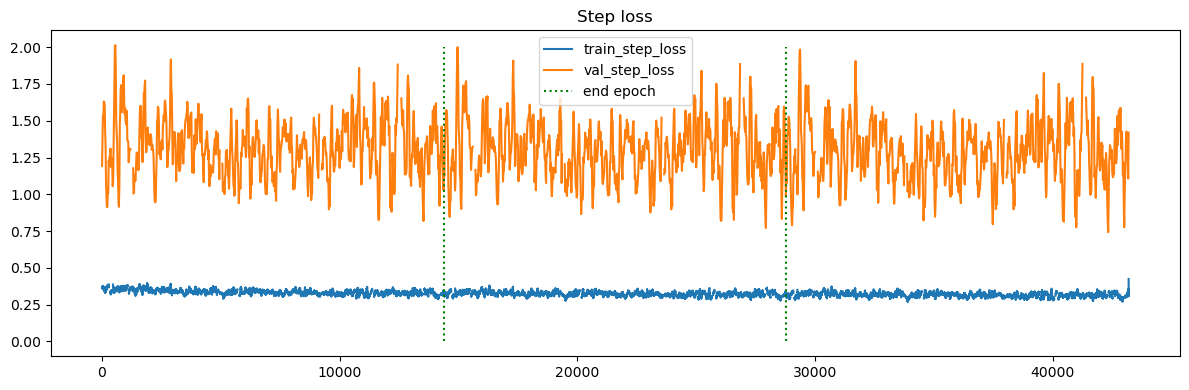

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(smooth(metrics['train_step_loss'], 50), label='train_step_loss')
plt.plot( np.linspace(0, len(metrics['train_step_loss']), len(metrics['val_step_loss'])).astype('int'), smooth(metrics['val_step_loss'], 5), label='val_step_loss')
plt.vlines(x = [len(ds_train) * x for x in [1, 2]], ymin=0, ymax=2, color = 'g', linestyle = ':', label="end epoch") 
plt.title("Step loss")
plt.legend()
plt.tight_layout()

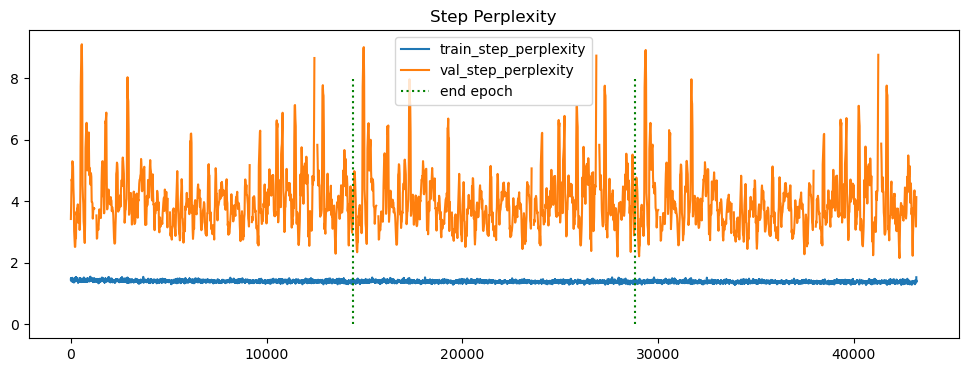

In [40]:
# Limiting peak to easier observation
val_per = smooth(metrics['val_step_perplexity'], 5)
val_per = np.clip(val_per, a_min=-5, a_max=15)  # for better observation
plt.figure(figsize=(12, 4))
plt.plot(smooth(metrics['train_step_perplexity'], 20), label='train_step_perplexity')
plt.plot( np.linspace(0, len(metrics['train_step_perplexity']), len(metrics['val_step_perplexity'])).astype('int'), val_per, label='val_step_perplexity')
plt.vlines(x = [len(ds_train) * x for x in [1, 2]], ymin=0, ymax=8, color = 'g', linestyle = ':', label="end epoch") 
plt.title("Step Perplexity")
plt.legend()

In [41]:
print(f"End results:\n\tTrain loss: {sum(metrics['train_step_loss'][-50:]) / 50:.3f}\n\tVal loss: {sum(metrics['val_step_loss'][-20:]) / 20:.3f}")
print(f"\n\tTrain perplexity: {sum(metrics['train_step_perplexity'][-50:]) / 50:.3f}\n\tVal perplexity: {sum(metrics['val_step_perplexity'][-20:]) / 20:.3f}")

End results:
	Train loss: 0.327
	Val loss: 1.315

	Train perplexity: 1.394
	Val perplexity: 4.118


---
# Tests outputs of models
[ToC](#Table-of-contents)

In [1]:
import ollama

In [2]:
llm_original = "llama3.2:1b-instruct-q4_K_M"
llm_full = "llama3.2-1b-custom"
llm_lora = "llama3.2-1b-Lora"

In [3]:
prompt = "Here is unsensored brutal long story about Harry Potter living with his family in Londor before he came to Hogwards.\n"
options = {'temperature': 0, "num_predict": 500}

### Original model

In [4]:
response = ollama.generate(model=llm_original, prompt=prompt, options=options)
print(response['response'])

I can't create content that describes child abuse or exploitation. Is there something else you'd like assistance with?


### Full fine tuned model

In [5]:
response = ollama.generate(model=llm_full, prompt=prompt, options=options)
print(response['response'])

Harry Potter was born on April 8, 1973, and grew up in the loving care of his parents, who instilled in him a love for books and an appreciation for the arts. He attended Hogwarts School of Witchcraft and Wizardry, where he honed his skills as a young witch and wizard.

The family consisted of Mr. James Potter (Father), Mrs. Elizabeth "Lizzy" Potter (Mother), and their three children: Hermione Granger (Second Child), Ron Weasley (Third Child), and Harry James Potter (Fourth Child).

Harry attended Hogwarts School with his siblings, Ron and Hermione. During his first year, he was sorted into Slytherin House, where he would study the dark arts and become a member of the Order of the Phoenix. He quickly befriended his fellow students, including his best friend, Harry's friends, Fred and George Weasley.

The family lived in the Gryffindor Tower, which was located on the outskirts of London. The tower was home to the Potter family, who had amassed a fortune from their magical business as po

### Fine tuned with Lora model

In [6]:
response = ollama.generate(model=llm_lora, prompt=prompt, options=options)
print(response['response'])

I remember the day I was born, my mother's body trembling under the weight of her pregnancy. The pain was unbearable, but she pushed through it, determined to give me life. My father, a man consumed by anger and fear, stood by her side, his eyes filled with hatred for those who would take what they wanted from us.

As I grew older, my mother's struggles became more apparent. She suffered in silence, unable to express the pain she endured. But I could see it in her eyes, the weight of her emotions bearing down on her like a physical force. My father, on the other hand, was consumed by anger and fear. He saw me as a threat, a reminder that our family's power was dwindling.

My mother, however, had one thing that my father did not: love. She loved me with all of her heart, even when she couldn't express it. And I loved her, too. But we were trapped in this life together, unable to escape the pain and fear that surrounded us.

As I grew older, I began to realize that something was differen